In [1]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import random

# once in a while there is a ConvergenceWarning, we're ignoring it for now
simplefilter("ignore", category=ConvergenceWarning)

# load the dataset
X, y = load_digits(return_X_y=True)

# get logistic regression model
model = LogisticRegression()

# instantiate a StandardScaler object
scaler = StandardScaler()

Preliminary data analysis:

In [2]:
print(f"Dataset shape: {X.shape}")

n_samples, n_features = X.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")

print(f"Feature value range: {np.min(X)} to {np.max(X)}")

classes = set(y)
print(f"Classes: {classes}")

print(f"Scale of the dataset: {np.mean(X)}")

print(f"Variance of the dataset: {np.var(X)}")

Dataset shape: (1797, 64)
Number of samples: 1797
Number of features: 64
Feature value range: 0.0 to 16.0
Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Scale of the dataset: 4.884164579855314
Variance of the dataset: 36.20173240585726


Evaluating the accuracy of different train-test ratios:

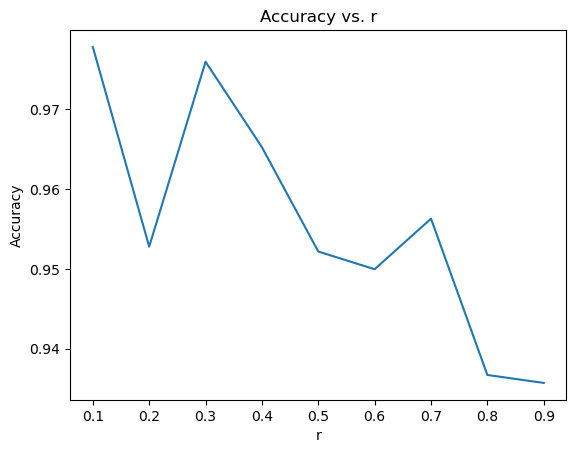

In [3]:
ratios = np.arange(start=0.1, stop=1, step=0.1)
accs = []

# scale the features in your data using the fit_transform() method
X_scaled = scaler.fit_transform(X)

for ratio in ratios:
    # split data into tarin and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=ratio)
    
    # clone and train
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, cloned_model.predict(X_test))
    accs.append(acc)
    # print(acc)

# plot the accuracy of each r using pyplot
plt.plot(ratios, accs)

# set the labels for the x and y axes and the title of the plot
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. r')

# display the plot
plt.show()


Creating an unbalanced subset of the dataset:

In [4]:
# sample 1000 indexes
X_indexes = range(X.shape[0])
unbalanced_indexes = random.sample(X_indexes, 1000)

X_unbalanced = X[unbalanced_indexes]
y_unbalanced = y[unbalanced_indexes]


# get frequencies
y_frequencies = {d:0 for d in classes}

for i in y_unbalanced:
    y_frequencies[i] += 1
    
y_min_frequency = min(y_frequencies.values())

print(f"y frequencies: {y_frequencies}")
print(f"y min frequency: {y_min_frequency}")
    

y frequencies: {0: 99, 1: 103, 2: 97, 3: 106, 4: 93, 5: 95, 6: 105, 7: 101, 8: 89, 9: 112}
y min frequency: 89


Creating a balanced subset of the unbalanced dataset:

In [5]:
X_balanced = np.empty((0, X_unbalanced.shape[1]))
y_balanced = np.empty(0)

for d in classes:
    # find the rows in X_unbalanced that correspond to the digit d ({0, 1, ..., 9})
    X_d = X_unbalanced[y_unbalanced == d]
    
    # randomly sample y_min_frequency data points from X_d
    indexes = random.sample(range(X_d.shape[0]), y_min_frequency)
    X_batch = X_d[indexes]
    
    y_batch = np.full((y_min_frequency, ), d)
    
    X_balanced = np.vstack((X_balanced, X_batch))
    y_balanced = np.append(y_balanced, y_batch)
    
# check that the new dataset is balanced
y_frequencies = {d:0 for d in classes}

for i in y_balanced:
    y_frequencies[i] += 1
    
print(f"y_balanced frequencies: {y_frequencies}")

y_balanced frequencies: {0: 89, 1: 89, 2: 89, 3: 89, 4: 89, 5: 89, 6: 89, 7: 89, 8: 89, 9: 89}


Evaluating the accuracy of different train-test ratios on the balanced subset:

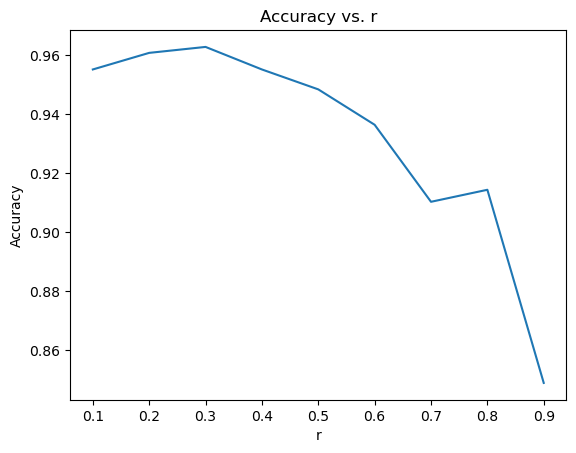

In [6]:
# scale the features in your data using the fit_transform() method
X_scaled = scaler.fit_transform(X_balanced)

# clear accs
accs = []

for ratio in ratios:
    # split data into tarin and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=ratio)
    
    # clone and train  
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, cloned_model.predict(X_test))
    accs.append(acc)
#     print(acc)
    
# plot the accuracy of each r using pyplot
plt.plot(ratios, accs)

# set the labels for the x and y axes and the title of the plot
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. r')

# display the plot
plt.show()

Naive k-features selection algorithm

In [7]:
def k_features_selection(X_train, X_test, y_train, y_test, k):

    # get all possible combinations of k features
    feature_combinations = combinations(range(X_train.shape[1]), k)
    
    best_accuracy = 0.0
    best_features = None
    
    for features in feature_combinations:
        
        # clone and train a logistic regression classifier using the current feature set
        cloned_model = clone(model)
        cloned_model.fit(X_train[:, list(features)], y_train)
        
        # make predictions on the test set and calculate the accuracy
        y_pred = cloned_model.predict(X_test[:, list(features)])
        accuracy = accuracy_score(y_test, y_pred)
        
        # update the best feature set and accuracy if the current feature set performs better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features
    
    return best_features, best_accuracy


# scale the features in your data using the fit_transform() method
X_scaled = scaler.fit_transform(X)

# split data into tarin and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

best_features, best_accuracy = k_features_selection(X_train, X_test, y_train, y_test, 2)
print("Best features: ", best_features)
print("Accuracy: ", best_accuracy)


        

Best features:  (21, 42)
Accuracy:  0.43333333333333335
